Correct data for background and save the results as an extra layer in the anndata object:

Load relevant packages and data:

In [1]:
import sys,os
path = '/nfs/team283/aa16/InSituCellTools/'
os.chdir(path)
sys.path.append(path)

In [2]:
import pickle
import anndata
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import diffxpy.api as de
from IPython.display import Image
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True' + ',dnn.enabled=False'
from isctools.ProbeCounts__GeneralModel_V2_SmoothedOverdispersion import ProbeCounts_GeneralModel_V2
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/nfs/users/nfs_a/aa16/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: Tesla V100-SXM2-32GB (0000:62:00.0)


In [3]:
adata_wta = pickle.load(open(path + "data/nanostringWTA_fetailBrain_AnnData.p", "rb" ))

In [4]:
adata_wta = adata_wta[adata_wta.obs['GoodQuality'],:]

Fit seperate model to each slide:

In [5]:
slides = np.array(('00MR', '00MU', ('00MV', '00MV-2'), '00MW'))
adata_slide = list()
for j in range(len(slides)):
    adata_slide.append(adata_wta[[adata_wta.obs['slide'][i] in slides[j] for i in range(len(adata_wta.obs['slide']))]])
    print(np.shape(adata_slide[j]))

(66, 18416)
(74, 18416)
(52, 18416)
(63, 18416)


In [6]:
counts_geneProbes = list()
counts_negativeProbes = list()
counts_nuclei = list()

for i in range(len(slides)):    
    
    counts_geneProbes.append(np.asarray(adata_slide[i][:,np.array(adata_slide[i].var != 'NegProbe-WTX').squeeze()].X))
    counts_negativeProbes.append(np.asarray(adata_slide[i][:,np.array(adata_slide[i].var =='NegProbe-WTX').squeeze()].X))
    counts_nuclei.append(np.asarray(adata_slide[i].obs['nuclei']).reshape(len(adata_slide[i].obs['nuclei']),1).squeeze())

In [7]:
models = list()
for i in range(len(slides)):
    models.append(ProbeCounts_GeneralModel_V2(
        X_data = counts_geneProbes[i],
        Y_data = counts_negativeProbes[i],
        nuclei = counts_nuclei[i],
        var_names = adata_wta.var_names[adata_wta.var_names != 'NegProbe-WTX'],
        n_factors = 15,
        v_mu_e_g = 0.25,
        v_mu_b_n_hyper = 0.25,
        mu_l_v_g = 0.01))

Fitting for slide:  00MR


Average Loss = 4.7117e+06: 100%|██████████| 300000/300000 [58:35<00:00, 85.33it/s]
Finished [100%]: Average Loss = 4.7117e+06


Average Loss = 4.7169e+06:  54%|█████▍    | 163452/300000 [32:17<27:22, 83.16it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 4.7142e+06:  70%|███████   | 210477/300000 [41:30<17:03, 87.47it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Average Loss = 4.7127e+06:  86%|████████▌ | 256593/300000 [50:33<08:15, 87.52it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in 

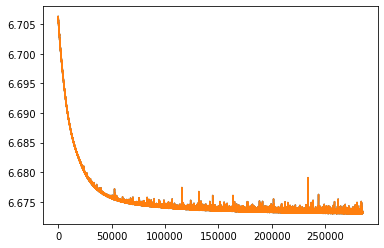

In [23]:
total_iterations = 3*10**5
for i in range(0,1):
    print('Fitting for slide: ', slides[i])
    models[i].fit_advi_iterative(n_iter = total_iterations, learning_rate = 0.001, n=2, method='advi')

Show training history:

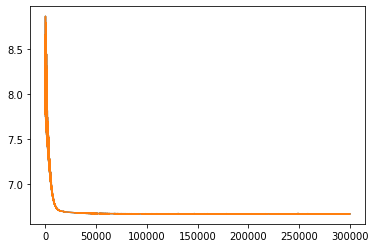

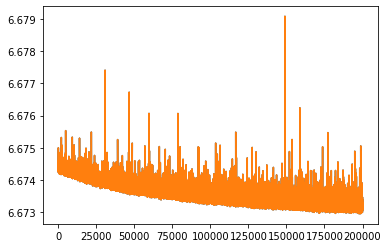

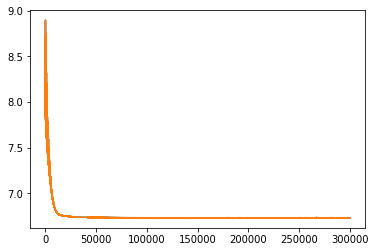

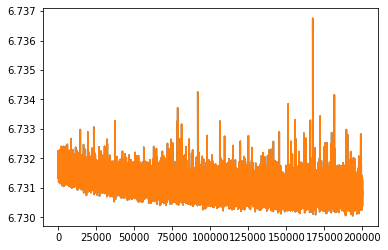

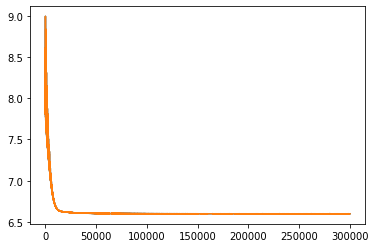

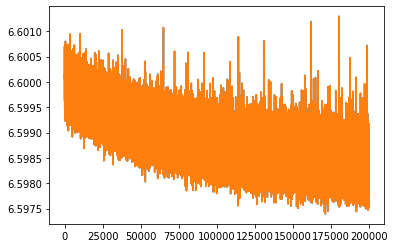

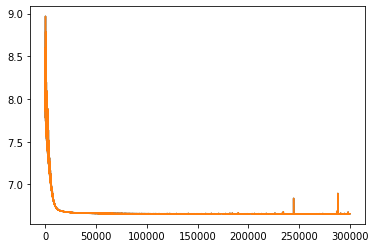

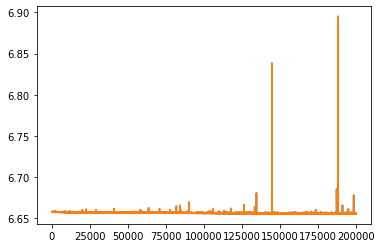

In [24]:
for i in range(len(slides)):
    models[i].plot_history()
    plt.show()
    models[i].plot_history(100000)
    plt.show()

In [10]:
pickle.dump(models, open("/nfs/team283/aa16/KR_NAS/data/CC-V2_AllModels2.p", "wb" ))

Sample posterior:

In [30]:
for i in range(len(slides)):
    print(slides[i])
    models[i].sample_posterior(node='all', n_samples=1000, save_samples=False);

00MR
00MU
('00MV', '00MV-2')
00MW


In [29]:
models[0].mean_field

{'init_1': <pymc3.variational.approximations.MeanField at 0x14b88f93a3d0>,
 'init_2': <pymc3.variational.approximations.MeanField at 0x14b885cd6250>}

Compute X_corrected and save results into anndata object:

In [31]:
for i in range(len(slides)):
    ProbeCounts_GeneralModel_V2.compute_X_corrected(models[i])

In [ ]:
adata_wta.layers['X_Corrected_V2'] = adata_wta.X
for j in range(len(slides)):
    subset_cells = [adata_wta.obs['slide'][i] in slides[j] for i in range(len(adata_wta.obs['slide']))]
    subset_genes = [adata_wta.var_names[i] in models[j].var_names for i in range(len(adata_wta.var_names))]
    adata_wta.layers['X_Corrected_V2'][subset_cells, :][:, subset_genes] = models[j].X_corrected_mean

In [ ]:
adata_wta.obs['TotalCounts_corrected_V2'] = np.sum(adata_wta.layers['X_Corrected_V2'], axis = 1)
adata_wta.layers['CPM_corrected_V2'] = np.asarray([adata_wta.layers['X_Corrected_V2'][i,:]/adata_wta.obs['TotalCounts_corrected_V2'][i] for i in range(len(adata_wta.obs['TotalCounts_corrected_V2']))])*10**6

In [ ]:
adata_wta.layers['X'] = adata_wta.X

In [ ]:
adata_wta.layers

In [ ]:
pickle.dump(adata_wta, open("/nfs/team283/aa16/KR_NAS/data/nanostringWTA_fetailBrain_AnnData.p", "wb" ))
pickle.dump(adata_wta, open("/nfs/team283/aa16/InSituCellTools/data/nanostringWTA_fetailBrain_AnnData.p", "wb" ))

Check what X_corrected_V2 looks like:

In [ ]:
genesOfInterest = np.array(('DLX1', 'STMN2', 'ELK1'))
ProbeCounts_GeneralModel_V2.plot_X_corrected_overview5(models[0], genesOfInterest, cmap = 'spring')

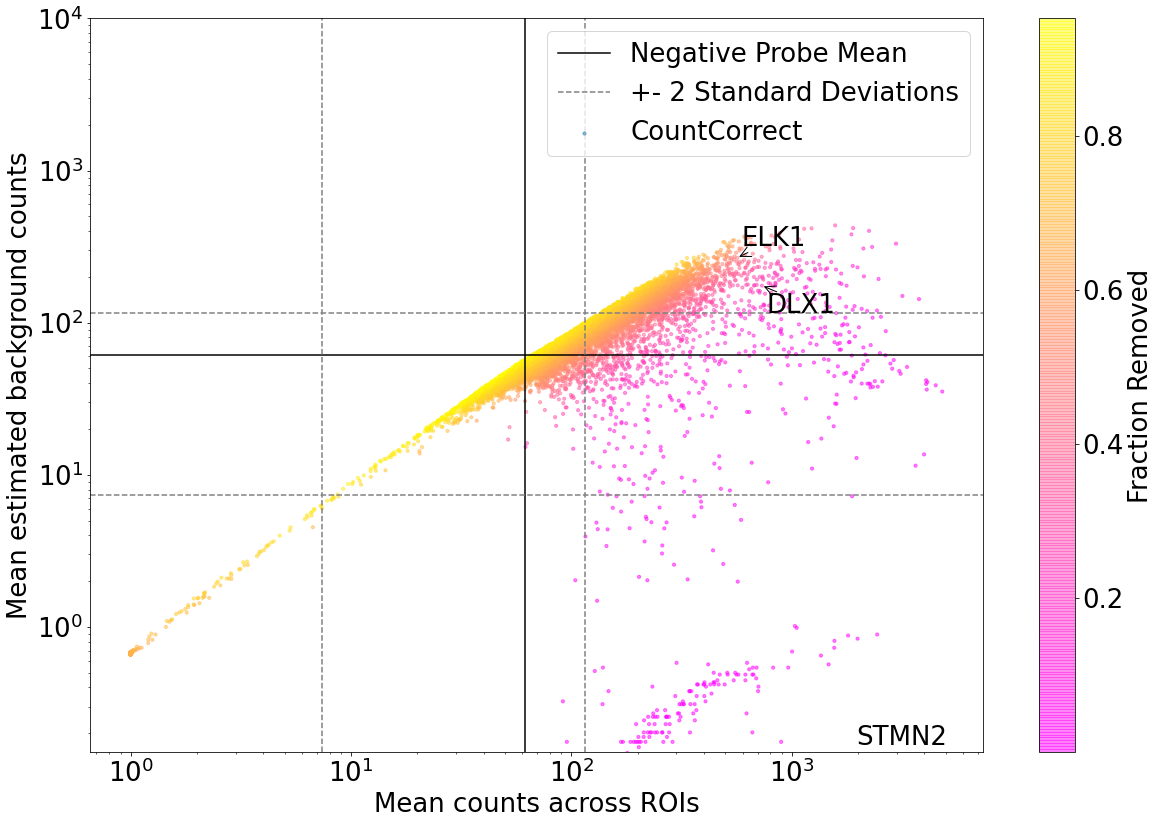

In [32]:
genesOfInterest = np.array(('DLX1', 'STMN2', 'ELK1'))
ProbeCounts_GeneralModel_V2.plot_X_corrected_overview5(models[1], genesOfInterest, cmap = 'spring', saveFig='/nfs/team283/aa16/KR_NAS/0_publication_figures/Figure1J_CC-V2_overview.pdf')

In [ ]:
genesOfInterest = np.array(('DLX1', 'STMN2', 'ELK1'))
ProbeCounts_GeneralModel_V2.plot_X_corrected_overview5(models[2], genesOfInterest, cmap = 'spring')

Example genes:

In [ ]:
example_genes = np.array(('DLX1', 'STMN2', 'ELK1'))
x = np.asarray(adata_slide[1].obs['VCDepth'])
order = np.where([adata_slide[1].obs['Radial_position'][i] == 2 for i in range(len(adata_slide[1].obs['Radial_position']))])[0]

In [ ]:
import imp
import isctools
from isctools import pymc3_model
imp.reload(isctools.pymc3_model)
imp.reload(isctools.ProbeCounts__GeneralModel_V2_SmoothedOverdispersion)
from isctools.ProbeCounts__GeneralModel_V2_SmoothedOverdispersion import ProbeCounts_GeneralModel_V2

In [ ]:
ProbeCounts_GeneralModel_V2.plot_X_corrected_exampleGenes1(models[1], x, order, example_genes, saveFig = 'ExampleCorrection.pdf')

In [ ]:
mod1 = models[1]

In [ ]:
adata_wta = adata_slide[1]

In [ ]:
# Get our HOPXpos and EOMESpos AOIs:
order_HOPX = np.where([adata_wta.obs['AOI_type'][i] == 'HOPXpos' for i in range(len(adata_wta.obs['Radial_position']))])[0]
order_EOMES = np.where([adata_wta.obs['AOI_type'][i] == 'EOMESpos' for i in range(len(adata_wta.obs['Radial_position']))])[0]
order = np.concatenate([order_HOPX, order_EOMES])

# Get cpm for both corrected (isc_cpm) and uncorrected data (cpm):
total_counts = np.sum(mod1.X_data, axis = 1)
cpm = mod1.X_data/total_counts.reshape(np.shape(mod1.X_data)[0],1)*10**6
isc_cpm = mod1.X_corrected_mean/total_counts.reshape(np.shape(mod1.X_data)[0],1)*10**6

# Put data into two AnnData objects:
adata_cpm = adata = sc.AnnData(X=cpm[order],
                               obs=pd.DataFrame(data = np.concatenate([np.repeat('HOPXpos', len(order_HOPX)),
                                                                      np.repeat('EOMESpos', len(order_EOMES))]),
                                                columns = ['Cell Type']))

adata_isc_cpm = adata = sc.AnnData(X=isc_cpm[order],
                               obs=pd.DataFrame(data = np.concatenate([np.repeat('HOPXpos', len(order_HOPX)),
                                                                      np.repeat('EOMESpos', len(order_EOMES))]),
                                                columns = ['Cell Type']))

# Perform differential expression with diffxpy for both cases:

test_rank_cpm = de.test.rank_test(
    data=adata_cpm,
    grouping="Cell Type",
    gene_names = mod1.var_names,
    ).summary()

test_rank_isc_cpm = de.test.rank_test(
    data=adata_isc_cpm,
    grouping="Cell Type",
    gene_names = mod1.var_names,
    ).summary()

In [ ]:
import statsmodels.stats.multitest as mult
test_rank_cpm['fdr'] = mult.multipletests(test_rank_cpm['pval'], method = 'fdr_bh')[1]
test_rank_isc_cpm['fdr'] = mult.multipletests(test_rank_isc_cpm['pval'], method = 'fdr_bh')[1]

In [ ]:
cpm_genes = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['qval'][i] < 0.05 and abs(test_rank_cpm['log2fc'][i]) > threshold for i in range(len(test_rank_cpm['fdr']))]])
isc_cpm_genes = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['qval'][i] < 0.05 and abs(test_rank_isc_cpm['log2fc'][i]) > threshold for i in range(len(test_rank_cpm['fdr']))]])

print(len(cpm_genes))
print(len(isc_cpm_genes))

In [ ]:
sc_de_results = pickle.load(open(path + 'data/oRG_IP_Polioudakis2019_DE_cpm_results.p', "rb"))

In [ ]:
threshold = 1

In [ ]:
group1_cpm = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['qval'][i] < 0.05 and test_rank_cpm['log2fc'][i] > threshold for i in range(len(test_rank_cpm['qval']))]])
group2_cpm = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['qval'][i] < 0.05 and test_rank_cpm['log2fc'][i] < -threshold for i in range(len(test_rank_cpm['qval']))]])
negatives_cpm = np.asarray(test_rank_cpm['gene'].loc[[test_rank_cpm['gene'][i] not in group1_cpm and test_rank_cpm['gene'][i] not in group2_cpm for i in range(len(test_rank_cpm['gene']))]])
                                    
group1_isc_cpm = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['qval'][i] < 0.05 and test_rank_isc_cpm['log2fc'][i] > threshold for i in range(len(test_rank_isc_cpm['qval']))]])
group2_isc_cpm = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['qval'][i] < 0.05 and test_rank_isc_cpm['log2fc'][i] < -threshold for i in range(len(test_rank_isc_cpm['qval']))]])
negatives_isc_cpm = np.asarray(test_rank_isc_cpm['gene'].loc[[test_rank_isc_cpm['gene'][i] not in group1_cpm and test_rank_isc_cpm['gene'][i] not in group2_cpm for i in range(len(test_rank_isc_cpm['gene']))]])

group1_reference = np.asarray(sc_de_results['gene'].loc[[sc_de_results['qval'][i] < 0.05 and sc_de_results['log2fc'][i] > threshold for i in range(len(sc_de_results['log2fc']))]])
group2_reference = np.asarray(sc_de_results['gene'].loc[[sc_de_results['qval'][i] < 0.05 and sc_de_results['log2fc'][i] < -threshold for i in range(len(sc_de_results['log2fc']))]])
negatives_reference = np.asarray(sc_de_results['gene'].loc[[sc_de_results['gene'][i] not in group1_reference and sc_de_results['gene'][i] not in group2_reference for i in range(len(sc_de_results['gene']))]])


In [ ]:
from adjustText import adjust_text

def plot_volcano_with_reference(log2fc, fdr, pval, genes, total, group1_reference, group2_reference,
                                genesOfInterest = None, n_max_genes = 1, alpha = 0.25, FDR_cutoff = 0.05,
                                height = 10, width = 10, posterios_samples = 1000, saveFig = None):
    r""" Make a volcano plot of the differential expression analysis.
    :genesOfInterest: numpy array of genes to annotate in the plot
    :n_max_genes: number of genes to automatically annotate at the extreme ends of the plot,
    i.e. the most differentially expressed genes
    :alpha: transparency of dots 
    :FDR_cutoff: what false discovery rate to use
    :height: height of figure
    :width: width of figure
    """
    
    fdr = fdr[np.abs(log2fc) < 1000]
    pval = pval[np.abs(log2fc) < 1000]
    genes = genes[np.abs(log2fc) < 1000]
    log2fc = log2fc[np.abs(log2fc) < 1000]
    
    subset2 = [g in group1_reference for g in genes]
    subset3 = [g in group2_reference for g in genes]
    
    # Set figure parameters:
    SMALL_SIZE = 20
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 20
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title    
    
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 1
    plt.rcParams['grid.color'] = "#cccccc"
    
    fig = plt.figure(figsize=(width, height))
    ax1 = plt.subplot2grid((2,3), (0, 0), rowspan=2, colspan = 2)
    ax2 = plt.subplot2grid((2,3), (0, 2))
    ax3 = plt.subplot2grid((2,3), (1, 2))
    
    colours = np.repeat('grey', len(log2fc))
    colours[[log2fc[i] > 1 and fdr[i] < FDR_cutoff for i in range(len(log2fc))]] = 'red'
    colours[[log2fc[i] < -1 and fdr[i] < FDR_cutoff for i in range(len(log2fc))]] = 'blue'
    ax1.scatter(log2fc, -np.log10(pval), c=colours, alpha = 0.1)
    #plt.hlines(np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]), np.amin(self.logFC['mean']),
    #           np.amax(self.logFC['mean']), linestyles = 'dashed')
    #plt.text(np.amin(self.logFC['mean']),np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]) + 0.01,
    #         'FDR < ' + str(FDR_cutoff))
    ax1.set_xlabel('Log2FC')
#     ax1.set_ylim(0,3.5)
#    ax1.set_xlim(-3,3)
    ax1.set_ylabel('-log10(p-value)')
    ax1.set_title('CountCorrect + Wilcoxon Test \n (' + 
                  str(total) +
                 ' genes with FDR < 0.05 and log2FC > 1)')
    plt.grid(True)
    
    if n_max_genes > 0:

        maxGenes = np.array((genes[np.argmax(log2fc)],
                             genes[np.argmin(log2fc)]))
        if genesOfInterest is None:
            genesOfInterest = maxGenes
        else:
            genesOfInterest = np.concatenate((genesOfInterest, maxGenes)) 

    if genesOfInterest is not None:

        geneIndex_to_annotate = np.squeeze([np.where(genes == genesOfInterest[i])
                                            for i in range(len(genesOfInterest))])
        
        ts = []    
        for i,j in enumerate(geneIndex_to_annotate):
            ts.append(ax1.text(log2fc[j], -np.log10(pval)[j], genesOfInterest[i]))
        adjust_text(ts, arrowprops=dict(arrowstyle='->', color='black'), ax = ax1, force_points = (5,5))
    
    colours = np.repeat('green', len(log2fc))
    ax2.scatter(log2fc[subset2], -np.log10(pval[subset2]),
                c=colours[subset2], alpha = 0.1)
    #plt.hlines(np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]), np.amin(self.logFC['mean']),
    #           np.amax(self.logFC['mean']), linestyles = 'dashed')
    #plt.text(np.amin(self.logFC['mean']),np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]) + 0.01,
    #         'FDR < ' + str(FDR_cutoff))
    ax2.set_xlabel('Log2FC')
#     ax2.set_ylim(0,3.5)
#     ax2.set_xlim(-3,4)
    ax2.set_ylabel('-log10(p-value)')
    ax2.set_title('oRG Marker Genes \n (n =' + str(sum(subset2)) + ')')
    plt.grid(True)
    
    colours = np.repeat('green', len(log2fc))
    ax3.scatter(log2fc[subset3], -np.log10(pval[subset3]),
                c=colours[subset3], alpha = 0.1)
    #plt.hlines(np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]), np.amin(self.logFC['mean']),
    #           np.amax(self.logFC['mean']), linestyles = 'dashed')
    #plt.text(np.amin(self.logFC['mean']),np.amin(self.logFC['probability'][self.logFC['FDR'] < FDR_cutoff]) + 0.01,
    #         'FDR < ' + str(FDR_cutoff))
    ax3.set_xlabel('Log2FC')
#     ax3.set_ylim(0,3.5)
#     ax3.set_xlim(-3,4)
    ax3.set_ylabel('-log10(p-value)')
    ax3.set_title('IP Marker Genes \n (n =' + str(sum(subset3)) + ')' )
    plt.grid(True)
    
    plt.tight_layout()
    if saveFig:
        plt.savefig(saveFig)
    plt.show()   

In [ ]:
plot_volcano_with_reference(np.array(test_rank_isc_cpm['log2fc']),
                            np.array(test_rank_isc_cpm['qval']),
                            np.array(test_rank_isc_cpm['pval']),
                            np.array(test_rank_isc_cpm['gene']),
                            532,
                            group1_reference, group2_reference,
                            width = 12, height = 10,
                            n_max_genes = 0,
                            alpha = 0.05,
                            genesOfInterest = np.array(('EOMES', 'HES6', 'PTN', 'VIM')),
                            saveFig = 'Figure4C_DE-Analysis.pdf')

In [36]:
models[3].mean_field

{'init_1': <pymc3.variational.approximations.MeanField at 0x14b8c5250fd0>,
 'init_2': <pymc3.variational.approximations.MeanField at 0x14b8c2e73790>}

In [38]:
models[1].X_corrected_mean

array([[ 37.,  10., 138., ..., 156.,  47.,  19.],
       [ 14.,  30., 111., ..., 184.,  67.,  38.],
       [ 13.,  17., 155., ..., 184.,  43.,  31.],
       ...,
       [ 13.,  23.,  45., ...,  74.,  24.,   6.],
       [ 23.,  44.,  70., ..., 141.,  49.,  20.],
       [  0.,   9.,   2., ...,  41.,  25.,  11.]], dtype=float32)